In [1]:
import numpy as np
import sympy as sp
import roboticstoolbox as rtb
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf

2023-05-07 17:35:55.456932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 17:35:56.118541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Matrices de transformacion

In [2]:
def sTrasl(x, y, z):
    """ Transformación homogénea que representa traslación pura
    """
    T = sp.Matrix([[1,0,0,x],
                   [0,1,0,y],
                   [0,0,1,z],
                   [0,0,0,1]])
    return T

def sTrotx(ang):
    """ Transformación homogénea que representa rotación alrededor de x
    """
    T = sp.Matrix([[1, 0,0,0],
                   [0, sp.cos(ang),-sp.sin(ang),0],
                   [0, sp.sin(ang), sp.cos(ang),0],
                   [0, 0, 0, 1]])
    return T

def sTrotz(ang):
    """ Transformación homogénea que representa rotación alrededor de z
    """
    T = sp.Matrix([[sp.cos(ang),-sp.sin(ang),0,0],
                   [sp.sin(ang), sp.cos(ang),0,0],
                   [0,0,1,0],
                   [0,0,0,1]])
    return T

In [3]:
# Variables que serán utilizadas
q1, q2, q3, q4, q5, q6 = sp.symbols("q1 q2 q3 q4 q5 q6")
l1, l2, l3, l4, l5, l6 = sp.symbols("l1 l2 l3 l4 l5 l6")

cos, sin = sp.cos, sp.sin
# Transformaciones con respecto al sistema anterior
T01 = sp.Matrix([
    [cos(q1), 0, -sin(q1), 0],
    [sin(q1), 0, cos(q1), 0],
    [0,-1,0, l1],
    [0,0,0,1]
])
 
T12 = sp.Matrix([
  [sin(q2), cos(q2), 0, l2*sin(q2)],
  [-cos(q2), sin(q2), 0, -l2*cos(q2)],
  [0,0,1,0],
  [0,0,0,1]
])

T23 = sp.Matrix([
    [cos(q3), 0, -sin(q3), l3*cos(q3)],
    [sin(q3), 0, cos(q3), l3*sin(q3)],
    [0,-1,0,0],
    [0,0,0,1]
])

T34 = sp.Matrix([
    [cos(q4), 0, sin(q4), 0],
    [sin(q4), 0, -cos(q4), 0],
    [0,1,0,l4],
    [0,0,0,1]
])

T45 = sp.Matrix([
    [cos(q5), 0, -sin(q5), 0],
    [sin(q5), 0, cos(q5), 0],
    [0, -1, 0, 0],
    [0,0,0,1]
])

T56 = sp.Matrix([
    [cos(q6), -sin(q6), 0, 0],
    [sin(q6), cos(q6), 0,0],
    [0,0,1,l6],
    [0,0,0,1]
])

T06 = sp.simplify(T01*T12*T23*T34*T45*T56)

print("T01:"); display(T01)
print("T12:"); display(T12)
print("T23:"); display(T23)
print("T34:"); display(T34)
print("T45:"); display(T45)
print("T56:"); display(T56)

T01:


Matrix([
[cos(q1),  0, -sin(q1),  0],
[sin(q1),  0,  cos(q1),  0],
[      0, -1,        0, l1],
[      0,  0,        0,  1]])

T12:


Matrix([
[ sin(q2), cos(q2), 0,  l2*sin(q2)],
[-cos(q2), sin(q2), 0, -l2*cos(q2)],
[       0,       0, 1,           0],
[       0,       0, 0,           1]])

T23:


Matrix([
[cos(q3),  0, -sin(q3), l3*cos(q3)],
[sin(q3),  0,  cos(q3), l3*sin(q3)],
[      0, -1,        0,          0],
[      0,  0,        0,          1]])

T34:


Matrix([
[cos(q4), 0,  sin(q4),  0],
[sin(q4), 0, -cos(q4),  0],
[      0, 1,        0, l4],
[      0, 0,        0,  1]])

T45:


Matrix([
[cos(q5),  0, -sin(q5), 0],
[sin(q5),  0,  cos(q5), 0],
[      0, -1,        0, 0],
[      0,  0,        0, 1]])

T56:


Matrix([
[cos(q6), -sin(q6), 0,  0],
[sin(q6),  cos(q6), 0,  0],
[      0,        0, 1, l6],
[      0,        0, 0,  1]])

#### Matriz de transformacion de todo el robot

In [4]:
print("T06:"); display(T06)

T06:


Matrix([
[((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*cos(q6) - (-sin(q1)*cos(q4) + sin(q4)*sin(q2 + q3)*cos(q1))*sin(q6), -((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*sin(q6) + (sin(q1)*cos(q4) - sin(q4)*sin(q2 + q3)*cos(q1))*cos(q6), -(sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*sin(q5) + cos(q1)*cos(q5)*cos(q2 + q3), l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3) - l6*sin(q1)*sin(q4)*sin(q5) - l6*sin(q5)*sin(q2 + q3)*cos(q1)*cos(q4) + l6*cos(q1)*cos(q5)*cos(q2 + q3)],
[ ((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*cos(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*sin(q6), -((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*sin(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*cos(q6), -(sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*sin(q5) + sin(q1)*cos(q5)*cos(q2 + 

### Clase y parametros DH para el robot con roboticstoolbox

In [17]:
class IRB120(rtb.DHRobot):

    q0 = [0,0,0,0,0,0] #Valores de q para posicion inicial
    
    def __init__(self):
        super().__init__(                
                [
                    rtb.RevoluteDH(offset=0, d=0.290, a=0,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=-np.pi/2, d=0, a=0.27,alpha=0),
                    rtb.RevoluteDH(offset=0, d=0, a=0.07,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0.302, a=0,alpha=np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0, a=0,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0.072, a=0,alpha=0),
                ], name="IRB 120"
                        )
robot = IRB120()
robot

DHRobot: IRB 120, 6 joints (RRRRRR), dynamics, standard DH parameters
┌──────────┬───────┬──────┬────────┐
│   θⱼ     │  dⱼ   │  aⱼ  │   ⍺ⱼ   │
├──────────┼───────┼──────┼────────┤
│ q1       │  0.29 │    0 │ -90.0° │
│ q2 - 90° │     0 │ 0.27 │   0.0° │
│ q3       │     0 │ 0.07 │ -90.0° │
│ q4       │ 0.302 │    0 │  90.0° │
│ q5       │     0 │    0 │ -90.0° │
│ q6       │ 0.072 │    0 │   0.0° │
└──────────┴───────┴──────┴────────┘

┌─┬──┐
└─┴──┘

In [6]:
robot.fkine([-1.51, -0.763, 1.85, -0.817, 0.9120, 2.320])

  -0.8055    0.07948  -0.5873   -0.04132   
  -0.01848   0.9871    0.1589   -0.004371  
   0.5923    0.1389   -0.7936    0.1932    
   0         0         0         1         


In [7]:
t06 = T06.evalf(subs={q1:-1.51, q2:-0.763, q3:1.85, q4:-0.817, q5:0.912, q6:2.3, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072})
final = np.array(t06).astype(np.float64)
final

array([[-0.80691514,  0.0633539 , -0.58725994, -0.04132001],
       [-0.03821904,  0.98654765,  0.15894353, -0.00437144],
       [ 0.5894296 ,  0.15069845, -0.79363891,  0.19322372],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [38]:
from sympy import sin, cos, Matrix
# Definir las funciones x, y, z
cos, sin = sp.cos, sp.sin

x = l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3)-l6*sin(q1)*sin(q4)*sin(q5) -l6*sin(q5)*sin(q2 +q3)*cos(q1)*cos(q4)+l6*cos(q1)*cos(q5)*cos(q2+q3)
y = l2*sin(q1)*sin(q2) + l3*sin(q1)*sin(q2+q3) + l4*sin(q1)*cos(q2+q3) - l6*sin(q1)*sin(q5)*sin(q2+q3)*cos(q4) + l6*sin(q1)*cos(q5)*cos(q2+q3)+l6*sin(q4)*sin(q5)*cos(q1)
z = l1 +l2*cos(q2)+l3*cos(q2+q3)-l4*sin(q2+q3)-l6*sin(q5)*cos(q4)*cos(q2+q3)-l6*sin(q2+q3)*cos(q5)
X = Matrix([x,y,z])
Y = Matrix([q1, q2, q3, q4, q5])
J = X.jacobian(Y)
J

Matrix([
[-l2*sin(q1)*sin(q2) - l3*sin(q1)*sin(q2 + q3) - l4*sin(q1)*cos(q2 + q3) + l6*sin(q1)*sin(q5)*sin(q2 + q3)*cos(q4) - l6*sin(q1)*cos(q5)*cos(q2 + q3) - l6*sin(q4)*sin(q5)*cos(q1), l2*cos(q1)*cos(q2) + l3*cos(q1)*cos(q2 + q3) - l4*sin(q2 + q3)*cos(q1) - l6*sin(q5)*cos(q1)*cos(q4)*cos(q2 + q3) - l6*sin(q2 + q3)*cos(q1)*cos(q5), l3*cos(q1)*cos(q2 + q3) - l4*sin(q2 + q3)*cos(q1) - l6*sin(q5)*cos(q1)*cos(q4)*cos(q2 + q3) - l6*sin(q2 + q3)*cos(q1)*cos(q5), -l6*sin(q1)*sin(q5)*cos(q4) + l6*sin(q4)*sin(q5)*sin(q2 + q3)*cos(q1), -l6*sin(q1)*sin(q4)*cos(q5) - l6*sin(q5)*cos(q1)*cos(q2 + q3) - l6*sin(q2 + q3)*cos(q1)*cos(q4)*cos(q5)],
[ l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3) - l6*sin(q1)*sin(q4)*sin(q5) - l6*sin(q5)*sin(q2 + q3)*cos(q1)*cos(q4) + l6*cos(q1)*cos(q5)*cos(q2 + q3), l2*sin(q1)*cos(q2) + l3*sin(q1)*cos(q2 + q3) - l4*sin(q1)*sin(q2 + q3) - l6*sin(q1)*sin(q5)*cos(q4)*cos(q2 + q3) - l6*sin(q1)*sin(q2 + q3)*cos(q5), l3*sin(q1)*cos(q2 + q3) - l4*sin(

In [41]:
Q = [-1.2725,	0.1765,	-0.2675,	1.2871,	1.7241,	1.7746]
q1, q2, q3, q4, q5, q6 = Q[0], Q[1], Q[2], Q[3], Q[4], Q[5]
J.evalf(subs={q1:-1.2725, q2:0.1765, q3:-0.2675, q4:1.2871, q5:1.7241, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072})

Matrix([
[0.297891116928786,  0.100548218708662,  0.0224300995461594, 0.0172129155484571,  -0.0309967963712848],
[0.163060151712845, -0.327017412064423, -0.0729504033003871, 0.0117870264713229,   0.0648970611596079],
[                0, -0.332657926202766,  -0.285249967839131, 0.0680286598362093, -0.00340148020179788]])

In [ ]:
import numpy as np
import math

def cinematica_inversa_RRP_Newton(Xdeseado, Qinicial, L, max_iter=100, epsilon=1e-4):
    """ 
        Esta funcion realiza la cinematica inversa de un robot RRP mediante el metodo
        de Newton

        Parametros

        - Xdeseado: Es un array de 3 espacios en donde se va a especificar las posiciones [x,y,z] deseadas
        - Qinicial: Es un array de 3 espacios con los valores ariculares iniciales del robot RRP
        - L = Es un array de 4 espacios con las distancias de cada uno de los eslabones del robot
        - max_iter: Es el numero maximo de iteraciones que va a hacer el algoritmo, por defecto son 100
        - epsilon: Es el error maximo que admite el algoritmo antes de llegar al limite de iteraciones, por defecto es 1e-4

        Retornos
        - q: Es un array de 3 espacios con los valores articulares finales
        - ee Es un array que almacena los errores obtenidos en cada iteracion

    """

    q = Qinicial.copy()
    ee = []

    for i in range(max_iter):
        q1 = q[0]; q2 = q[1]; q3 = q[2]
        J = np.array([[L[1]*np.sin(q1)-L[2]*np.cos(q1+q2), -L[2]*np.cos(q1+q2), 0],
                      [-L[1]*np.cos(q1)-L[2]*np.sin(q1+q2), -L[2]*np.sin(q1+q2), 0],
                      [0                              ,                 0, 1]])

        f = np.array([-L[1]*np.cos(q1)-L[2]*np.sin(q1+q2), -L[1]*np.sin(q1) + L[2]*np.cos(q1+q2), L[2]-L[3]+q3])
        e = Xdeseado-f
        q = q + np.dot(np.linalg.pinv(J),e)

        enorm = np.linalg.norm(e)
        print("Error en la iteración {}: {}".format(i, np.round(enorm,4)))
        ee.append(enorm)  

        if (enorm < epsilon):
            break
    return q, ee


# Parámetros del robot

L = np.array([0.395, 0.33, 0.405, 0.395])


qinit  = np.array([0, 0, 0])



xd = np.array([0.4, 0.345, 0.47])
epsilon = 1e-4        
max_iteraciones = 100 
 
q, e = cinematica_inversa_RRP_Newton(xd, qinit, L, max_iteraciones, epsilon)
print("\nValores articulares obtenidos:", np.round(q,4))

### Lectura de datos

In [3]:
data = pd.read_csv('datos_IRB120rpy.csv')
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Roll,Pitch,Yaw,X,Y,Z
0,-1.2725,0.1765,-0.2675,1.2871,1.7241,1.7746,2.670896,1.240142,3.079316,0.16306,-0.29789,0.63213
1,2.1500,-0.3738,0.5203,-0.9932,-0.1559,0.3500,1.673083,-0.938626,-2.514319,-0.16200,0.23058,0.56218
2,2.4630,0.0588,0.1829,2.5025,0.8853,1.4526,0.929903,0.714333,-2.159952,-0.31731,0.21315,0.58774
3,-0.2220,-1.2199,0.8517,1.3264,-0.6319,4.3036,0.664402,-1.002397,1.485717,0.04312,-0.05204,0.58733
4,-2.8115,-0.5678,0.7310,0.8337,1.6392,5.3698,-2.387837,-0.468515,-2.128698,-0.12604,-0.09941,0.49080


In [19]:
robot.fkine([-1.2725,	0.1765,	-0.2675,	1.2871,	1.7241,	1.7746])

  -0.324    -0.3726    0.8696    0.1631    
   0.02021   0.9162    0.4002   -0.2979    
  -0.9458    0.1472   -0.2894    0.6321    
   0         0         0         1         


#### Separando datos de labels

In [11]:
data.shape

(100000, 9)

In [20]:
X = data.loc[:, ['X', 'Y', 'Z']]
y = data.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
def error_NR(qp:np.array, Q:np.array):
    q1, q2, q3, q4, q5, q6 = sp.symbols("q1 q2 q3 q4 q5 q6")
    sin, cos = sp.sin, sp.cos
    x = l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3)-l6*sin(q1)*sin(q4)*sin(q5) -l6*sin(q5)*sin(q2 +q3)*cos(q1)*cos(q4)+l6*cos(q1)*cos(q5)*cos(q2+q3)
    y = l2*sin(q1)*sin(q2) + l3*sin(q1)*sin(q2+q3) + l4*sin(q1)*cos(q2+q3) - l6*sin(q1)*sin(q5)*sin(q2+q3)*cos(q4) + l6*sin(q1)*cos(q5)*cos(q2+q3)+l6*sin(q4)*sin(q5)*cos(q1)
    z = l1 +l2*cos(q2)+l3*cos(q2+q3)-l4*sin(q2+q3)-l6*sin(q5)*cos(q4)*cos(q2+q3)-l6*sin(q2+q3)*cos(q5)
    X = Matrix([x,y,z])
    Y = Matrix([q1, q2, q3, q4, q5])
    J = X.jacobian(Y)
    q1, q2, q3, q4, q5, q6 = Q[0], Q[1], Q[2], Q[3], Q[4], Q[5]
    Je = J.evalf(subs={q1:q1, q2:q2, q3:q3, q4:q4, q5:q5, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072})

    f = np.array([x.evalf(subs={q1:q1, q2:q2, q3:q3, q4:q4, q5:q5, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072}), 
         y.evalf(subs={q1:q1, q2:q2, q3:q3, q4:q4, q5:q5, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072}), 
         z.evalf(subs={q1:q1, q2:q2, q3:q3, q4:q4, q5:q5, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072})])

    T = np.array(robot.fkine(qp))
    x = np.around(T[0,-1], 5)
    y = np.around(T[1,-1], 5)
    z = np.around(T[2,-1], 5)
    xd = [x,y,z]
    e = xd - f

    q = Q + np.dot(np.linalg.pinv(Je),e)

    enorm = np.linalg.norm(e)

    return enorm

In [51]:
error_NR([-1.5,	1.1765,	-0.2975,	1.7871,	1.2241,	1.946], [-1.2725,	0.1765,	-0.2675,	1.2871,	1.7241,	1.7746])

UFuncTypeError: Cannot cast ufunc 'svd_m_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=0.1), input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(6, activation = 'linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=error_NR, metrics=['mse'])

In [31]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weightsT1.h5',
                                       monitor='val_loss', save_best_only=True)
# Entrena el modelo
history = model.fit(X_train, y_train,  epochs=20, batch_size=128,
                    validation_split=0.2, callbacks=[checkpoint_callback])

plt.plot(history.history['loss'], label='pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='pérdida de validación')
plt.xlabel('Número de épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Epoch 1/20


NotImplementedError: in user code:

    File "/home/jhonf/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_5712/2591330252.py", line 4, in error_NR  *
        x = l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3)-l6*sin(q1)*sin(q4)*sin(q5) -l6*sin(q5)*sin(q2 +q3)*cos(q1)*cos(q4)+l6*cos(q1)*cos(q5)*cos(q2+q3)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (error_NR/strided_slice_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [8]:
class IRB120_dataset(Dataset):

    def __init__(self, X_train, y_train):
        self.x_data, self.y_data = X_train, y_train
  
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

    def __len__(self):
      return len(self.y_data)

IRB_120_data = IRB120_dataset(X_train, y_train)

In [9]:
batch_size = 5000
loader = DataLoader(dataset=IRB_120_data, batch_size=batch_size, shuffle=True)

In [10]:
class IK_IRB120(nn.Module):

  def __init__(self):
    super(IK_IRB120, self).__init__()
    # input layer
    self.input_layer_to_hidden_layer_1 = nn.Linear(3, 16, bias=True)
    self.bn1 = nn.BatchNorm1d(16)
    # relu 1
    self.relu1 = nn.ReLU()

    # hidden layer 1
    self.hidden_layer_1_to_hidden_layer_2 = nn.Linear(16, 60, bias=True)
    self.bn2 = nn.BatchNorm1d(60)
    # relu 2
    self.relu2 = nn.ReLU()

    # hidden layer 2
    self.hidden_layer_2_to_hidden_layer_3 = nn.Linear(60, 100, bias = True)
    self.bn3 = nn.BatchNorm1d(100)
    self.relu3 = nn.ReLU()
    
     # hidden layer 3
    self.hidden_layer_3_to_hidden_layer_4 = nn.Linear(100, 200, bias = True)
    self.bn4 = nn.BatchNorm1d(200)
    self.relu3 = nn.ReLU()

     # hidden layer 4
    self.hidden_layer_4_to_hidden_layer_5 = nn.Linear(200, 100, bias = True)
    self.relu3 = nn.ReLU()

    # hidden layer 5
    self.hidden_layer_5_to_output_layer = nn.Linear(100, 6, bias = True)
    # ActivationF
    self.activationf = nn.Identity()

  def forward(self, input):

    # input layer
    linear_combination1 = self.input_layer_to_hidden_layer_1(input)
    batch_n1 = self.bn1(linear_combination1)
    intermediate_relu1 = self.relu1(batch_n1)

    # hidden layer 1
    linear_combination2 = self.hidden_layer_1_to_hidden_layer_2(intermediate_relu1)
    batch_n2 = self.bn2(linear_combination2)
    intermediate_relu2 = self.relu2(batch_n2)

    # hidden layer 2
    linear_combination3 = self.hidden_layer_2_to_hidden_layer_3(intermediate_relu2)
    batch_n3 = self.bn3(linear_combination3)
    intermediate_relu3 = self.relu3(batch_n3)

    # hidden layer 3
    linear_combination4 = self.hidden_layer_3_to_hidden_layer_4(intermediate_relu3)
    batch_n4 = self.bn4(linear_combination4)
    intermediate_relu4 = self.relu3(batch_n4)

    # hidden layer 4
    linear_combination5 = self.hidden_layer_4_to_hidden_layer_5(intermediate_relu4)
    intermediate_relu5 = self.relu3(linear_combination5)

    # hidden layer 5
    linear_combination6 = self.hidden_layer_5_to_output_layer(intermediate_relu5)
    out = self.activationf(linear_combination6)

    return out

#### Entrenamiento

In [11]:
irb120 = IK_IRB120().to(device)

In [29]:
print(irb120)

IK_IRB120(
  (input_layer_to_hidden_layer_1): Linear(in_features=3, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (hidden_layer_1_to_hidden_layer_2): Linear(in_features=16, out_features=60, bias=True)
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (hidden_layer_2_to_hidden_layer_3): Linear(in_features=60, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (hidden_layer_3_to_hidden_layer_4): Linear(in_features=100, out_features=200, bias=True)
  (bn4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layer_4_to_hidden_layer_5): Linear(in_features=200, out_features=100, bias=True)
  (hidden_layer_5_to_output_layer): Linear(in_features=100, out_features=6, bias=True)
  (activationf): Identity()
)


In [12]:
epochs = 500
optimizer = torch.optim.Adam(irb120.parameters(), lr = 0.001)
loss_function = torch.nn.MSELoss()

losses = []
for epoch in range(epochs):
  mini_batch_losses = []
  for i, (features, labels) in enumerate(loader):
   
    Y_prediction = irb120.forward(features)

    loss = loss_function(Y_prediction, labels) 

    irb120.zero_grad()

    loss.backward()

    optimizer.step()

    # keep track of losses
    mini_batch_losses.append(loss.detach().cpu().numpy()) # we can only execute numpy code on the cpu

  mini_batch_mean_loss = np.mean(mini_batch_losses)
  losses.append(mini_batch_mean_loss)
  if epoch % 100 == 0:
    print(f"Loss in Epoch {epoch}: {np.mean(losses)}")

Loss in Epoch 0: 1.3309848308563232
Loss in Epoch 100: 0.8636678457260132
Loss in Epoch 200: 0.8524742126464844
Loss in Epoch 300: 0.84409499168396
Loss in Epoch 400: 0.8366373777389526


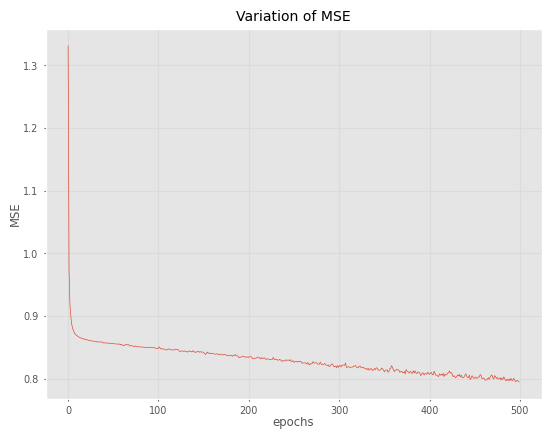

In [13]:
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Variation of MSE')
plt.show()

#### Test

In [14]:
y_test_predictions = irb120.forward(X_test)

In [15]:
metrics.mean_squared_error(y_test.detach().cpu().numpy(), y_test_predictions.detach().cpu().numpy())

0.9264514

In [16]:
metrics.mean_absolute_error(y_test.detach().cpu().numpy(), y_test_predictions.detach().cpu().numpy())

0.6236167

In [17]:
metrics.r2_score(y_test.detach().cpu().numpy(), y_test_predictions.detach().cpu().numpy())

0.4202655373625616

In [76]:
X_test.shape

torch.Size([10000, 3])

In [102]:
xd = torch.tensor([[-0.01303, 0.09884, 0.1727],[-0.01303, 0.09884, 0.1727]])
pp = irb120.forward(xd)
pp

tensor([[ 0.8869, -0.4880,  0.3405,  0.0355,  0.1483,  0.1662],
        [ 0.8869, -0.4880,  0.3405,  0.0355,  0.1483,  0.1662]],
       grad_fn=<AddmmBackward0>)

In [92]:
pp.detach().cpu().numpy()[0]

array([ 0.20298198, -0.52858156,  0.38583338, -0.01641543,  0.18788901,
       -0.09114856], dtype=float32)

In [103]:
robot.fkine(pp.detach().cpu().numpy()[0])

   0.1561    0.7626    0.6277    0.1474    
  -0.125    -0.6152    0.7784    0.1815    
   0.9798   -0.2      -0.000688  0.6421    
   0         0         0         1         


In [142]:
tt = robot.fkine([2.0719,	0.3370,	1.4658,	1.0830,	-0.6027,	-0.0833])
tt

   0.3252    0.8541    0.406    -0.01303   
   0.8347   -0.461     0.3012    0.09884   
   0.4444    0.2409   -0.8628    0.1727    
   0         0         0         1         


#### TensorFlow

In [5]:
import tensorflow as tf

In [4]:
datarp = pd.read_csv('datos_IRB120rpy.csv')
datarp.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Roll,Pitch,Yaw,X,Y,Z
0,0.2761,0.6721,-0.4352,-0.1295,0.0584,-1.6458,1.871628,0.197542,0.14859,0.52643,0.14859,0.47753
1,1.7708,1.1330,-0.7564,-1.0195,-0.6086,2.4487,-1.594067,-0.036760,0.59477,-0.15635,0.59477,0.35682
2,1.7675,1.4063,1.1626,-0.3012,-1.3534,-2.4581,2.706901,0.118880,0.06831,-0.03488,0.06831,0.04689
3,0.0402,0.8588,0.8957,-0.0314,-0.6632,-1.9252,2.685973,0.155367,0.01149,0.25100,0.01149,0.09282
4,2.7801,-1.4877,0.0104,-0.7476,0.3315,2.2397,-0.358464,0.192481,-0.08664,0.27418,-0.08664,0.68580


In [6]:
from spatialmath.base import *

T = rpy2tr(2.8693025426723797, -0.4605050302546952, 1.1993012554645106)
T
r,p,y = tr2rpy(np.array(tt))
print(r,p,y)
print(T)


NameError: name 'tt' is not defined

In [7]:
datarp.shape

(100000, 12)

In [32]:
X = data.loc[:, ['Roll', 'Pitch', 'Yaw', 'X', 'Y', 'Z']]
y = data.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]

In [33]:
# Supongamos que tus datos de entrada son `X` y tus etiquetas son `y`


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:

# Definición de las entradas
input_rp = tf.keras.layers.Input(shape=(3,), name='input_rp')
input_xyz = tf.keras.layers.Input(shape=(3,), name='input_xyz')

# Capas ocultas
dense_rp1 = tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_rp1')(input_rp)
dense_rp1 = tf.keras.layers.Dropout(0.2)(dense_rp1) # Capa de dropout para input_rp
dense_rp2 = tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_rp2')(dense_rp1)
dense_rp2 = tf.keras.layers.Dropout(0.2)(dense_rp2) # Capa de dropout para input_rp
dense_rp3 = tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_rp3')(dense_rp2)
dense_rp3 = tf.keras.layers.Dropout(0.2)(dense_rp3) # Capa de dropout para input_rp

dense_xyz1 = tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_xyz1')(input_xyz)
dense_xyz1 = tf.keras.layers.Dropout(0.2)(dense_xyz1) # Capa de dropout para input_xyz
dense_xyz2 = tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_xyz2')(dense_xyz1)
dense_xyz2 = tf.keras.layers.Dropout(0.2)(dense_xyz2) # Capa de dropout para input_xyz
dense_xyz3 = tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=0.01), name='dense_xyz3')(dense_xyz2)
dense_xyz3 = tf.keras.layers.Dropout(0.2)(dense_xyz3) # Capa de dropout para input_xyz

# Concatenación de las capas ocultas
concat = tf.keras.layers.Concatenate(name='concat')([dense_rp2, dense_xyz2])

# Capa de salida
output = tf.keras.layers.Dense(6, activation='linear', name='output')(concat)

# Definición del modelo
model = tf.keras.models.Model(inputs=[input_rp, input_xyz], outputs=output)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'accuracy'])


In [140]:
X_test.shape

(20000, 6)

Epoch 1/10
500/500 [==============================] - 2s 4ms/step - loss: 1.6685 - mse: 1.6685 - accuracy: 0.7523 - val_loss: 1.6553 - val_mse: 1.6553 - val_accuracy: 0.7611
Epoch 2/10
500/500 [==============================] - 2s 3ms/step - loss: 1.6679 - mse: 1.6679 - accuracy: 0.7523 - val_loss: 1.6557 - val_mse: 1.6557 - val_accuracy: 0.7611
Epoch 3/10
500/500 [==============================] - 2s 3ms/step - loss: 1.6678 - mse: 1.6678 - accuracy: 0.7521 - val_loss: 1.6567 - val_mse: 1.6567 - val_accuracy: 0.7612
Epoch 4/10
500/500 [==============================] - 2s 3ms/step - loss: 1.6672 - mse: 1.6672 - accuracy: 0.7523 - val_loss: 1.6544 - val_mse: 1.6544 - val_accuracy: 0.7612
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 1.6667 - mse: 1.6667 - accuracy: 0.7521 - val_loss: 1.6543 - val_mse: 1.6543 - val_accuracy: 0.7613
Epoch 6/10
500/500 [==============================] - 2s 3ms/step - loss: 1.6659 - mse: 1.6659 - accuracy: 0.7522 - val_loss: 1.65

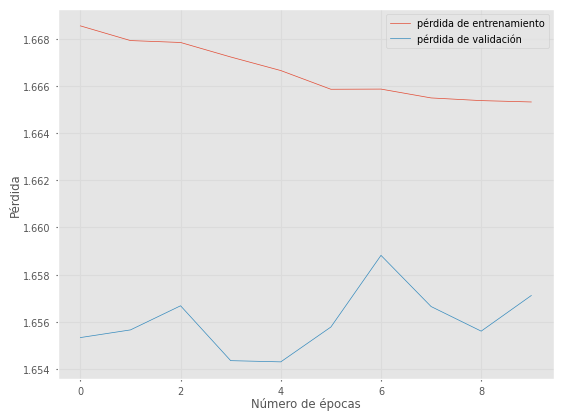

In [92]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weightsT1.h5',
                                       monitor='val_loss', save_best_only=True)

history = model.fit([X_train[['Roll', 'Pitch', 'Yaw']].values, X_train[['X', 'Y', 'Z']].values], y_train.values, batch_size=128,epochs=10, validation_split=0.2, callbacks=[checkpoint_callback])
plt.plot(history.history['loss'], label='pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='pérdida de validación')
plt.xlabel('Número de épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [99]:
model.evaluate([X_test[['Roll', 'Pitch', 'Yaw']].values, X_test[['X', 'Y', 'Z']].values], y_test.values)

625/625 [==============================] - 1s 2ms/step - loss: 1.6491 - mse: 1.6491 - accuracy: 0.7510


[1.6491187810897827, 1.6491187810897827, 0.7509999871253967]

In [64]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Roll,Pitch,Yaw,X,Y,Z
0,-1.2725,0.1765,-0.2675,1.2871,1.7241,1.7746,2.670896,1.240142,3.079316,0.16306,-0.29789,0.63213
1,2.1500,-0.3738,0.5203,-0.9932,-0.1559,0.3500,1.673083,-0.938626,-2.514319,-0.16200,0.23058,0.56218
2,2.4630,0.0588,0.1829,2.5025,0.8853,1.4526,0.929903,0.714333,-2.159952,-0.31731,0.21315,0.58774
3,-0.2220,-1.2199,0.8517,1.3264,-0.6319,4.3036,0.664402,-1.002397,1.485717,0.04312,-0.05204,0.58733
4,-2.8115,-0.5678,0.7310,0.8337,1.6392,5.3698,-2.387837,-0.468515,-2.128698,-0.12604,-0.09941,0.49080


In [74]:
model.save('modelT3.h5')

In [9]:
model = tf.keras.models.load_model('modelT3.h5')

In [100]:
Xtt = np.array([X_test[['Roll', 'Pitch', 'Yaw']].values, X_test[['X', 'Y', 'Z']].values])
Xtt.shape

(2, 20000, 3)

In [96]:
Xtt[0]

array([-2.819115  ,  1.02517465,  2.65695258])

In [79]:
X_test

,Roll,Pitch,Yaw,X,Y,Z
75721,-2.819115,1.025175,2.656953,-0.06460,-0.23208,0.30589
80184,-0.931517,0.391443,-2.131935,0.07944,0.04488,0.68195
19864,-2.183693,0.172945,1.014335,0.24132,0.45144,0.07288
76699,-0.132965,-1.209336,-1.333357,0.50896,-0.06338,0.34387
92991,-0.686641,0.267635,0.270429,0.50166,-0.15566,0.53924
...,...,...,...,...,...,...
32595,-2.142501,-0.520417,1.539000,0.10283,0.09732,0.47664
29313,-0.922177,0.482835,-0.589395,-0.30652,-0.09723,0.55050
37862,-0.673745,0.139645,3.050429,0.04161,-0.39027,0.80735
53421,2.391338,-0.384632,-2.139484,-0.28650,-0.09046,0.76129


In [85]:
xp = np.array([[[-2.819115,	1.025175,	2.656953],[-2.819115,	1.025175,	2.656953]],[[-0.06460,	-0.23208,	0.30589],[-0.06460,	-0.23208,	0.30589]]])
xp.shape

(2, 2, 3)

In [102]:
y_pred = model.predict([X_test[['Roll', 'Pitch', 'Yaw']].values, X_test[['X', 'Y', 'Z']].values])

625/625 [==============================] - 1s 1ms/step


In [26]:
y_test

,Q1,Q2,Q3,Q4,Q5,Q6
75721,-2.0903,-0.0262,1.0365,1.5497,0.9640,0.4667
80184,1.1576,-0.7065,0.4407,-2.2568,1.7584,3.1543
19864,0.9654,1.5383,-0.6707,1.0440,1.2213,5.6684
76699,-0.2480,1.0782,-0.5252,-1.4215,-2.0403,1.1664
92991,2.7547,-1.3790,-1.0515,-0.7217,1.2493,1.1288
...,...,...,...,...,...,...
32595,-2.7045,-1.8696,0.7823,2.4667,-1.6945,4.4494
29313,0.3600,-1.8136,0.0820,0.2601,1.1612,2.2014
37862,-1.4175,0.6928,-1.4246,0.9363,-0.3242,0.5515
53421,-2.7376,0.5099,-1.4441,2.7127,-1.7540,2.4496


In [107]:
y_test.values[1]

array([ 1.1576, -0.7065,  0.4407, -2.2568,  1.7584,  3.1543])

In [108]:
y_pred[1]

array([-0.46708545, -1.0350844 ,  0.37998235, -0.0068084 , -0.06153574,
        3.0367017 ], dtype=float32)

In [112]:
print('Prueba')
robot.fkine(y_pred[2])

Prueba


   0.007329 -0.3068    0.9517    0.5455    
  -0.3082    0.9047    0.294     0.1692    
  -0.9513   -0.2955   -0.08794   0.5237    
   0         0         0         1         


In [111]:
print("Real")
robot.fkine(y_test.values[2])

Real


   0.5203    0.4141   -0.7469    0.2413    
   0.8365   -0.4234    0.348     0.4514    
  -0.1721   -0.8058   -0.5667    0.07288   
   0         0         0         1         


In [99]:

# Crear el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,), name='roll_pitch_yaw'),
    tf.keras.layers.Dense(32, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Input(shape=(3,), name='xyz'),
    tf.keras.layers.Dense(32, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.concatenate(),
    tf.keras.layers.Dense(64, activation=tf.keras.layers.ELU(alpha=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(6, activation='linear', name='output')
])

# Compilar el modelo con la función de pérdida y el optimizador adecuados
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.001), metrics=['mae', 'mse'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weightsT1.h5',
                                       monitor='val_loss', save_best_only=True)
# Entrenar el modelo
history = model.fit({'roll_pitch_yaw': X_trainr, 'xyz': X_trainp}, y_trainr, 
                    validation_data=({'roll_pitch_yaw': X_valr, 'xyz': X_valp}, y_valr), 
                    epochs=100, batch_size=32, callbacks=[checkpoint_callback])


TypeError: concatenate() missing 1 required positional argument: 'inputs'

In [94]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rpy_input (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 xyz_input (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 6)            0           ['rpy_input[0][0]',              
                                                                  'xyz_input[0][0]']              
                                                                                                  
 dense_37 (Dense)               (None, 128)          896         ['concatenate_1[0][0]']    

In [2]:
data = pd.read_csv('datos_IRB120rpy.csv')
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Roll,Pitch,Yaw,X,Y,Z
0,-1.2725,0.1765,-0.2675,1.2871,1.7241,1.7746,2.670896,1.240142,3.079316,0.16306,-0.29789,0.63213
1,2.1500,-0.3738,0.5203,-0.9932,-0.1559,0.3500,1.673083,-0.938626,-2.514319,-0.16200,0.23058,0.56218
2,2.4630,0.0588,0.1829,2.5025,0.8853,1.4526,0.929903,0.714333,-2.159952,-0.31731,0.21315,0.58774
3,-0.2220,-1.2199,0.8517,1.3264,-0.6319,4.3036,0.664402,-1.002397,1.485717,0.04312,-0.05204,0.58733
4,-2.8115,-0.5678,0.7310,0.8337,1.6392,5.3698,-2.387837,-0.468515,-2.128698,-0.12604,-0.09941,0.49080


In [135]:
data.shape

(100000, 12)

In [8]:
X = data.loc[:, ['Roll','Pitch','Yaw','X', 'Y', 'Z']].values
y = data.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=1.0), input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=1.0), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=1.0)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.keras.layers.ELU(alpha=1.0)),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.keras.layers.ELU(alpha=1.0)),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.keras.layers.ELU(alpha=1.0), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tf.keras.layers.ELU(alpha=1.0)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(6, activation = 'linear')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mse', metrics=['mse', 'accuracy'])

In [22]:
model = tf.keras.models.load_model('modelT1.h5')

Epoch 1/10
500/500 [==============================] - 11s 21ms/step - loss: 1.7534 - mse: 1.7188 - accuracy: 0.7523 - val_loss: 1.7371 - val_mse: 1.7027 - val_accuracy: 0.7612
Epoch 2/10
500/500 [==============================] - 12s 24ms/step - loss: 1.7501 - mse: 1.7159 - accuracy: 0.7523 - val_loss: 1.7448 - val_mse: 1.7099 - val_accuracy: 0.7612
Epoch 3/10
500/500 [==============================] - 14s 28ms/step - loss: 1.7472 - mse: 1.7132 - accuracy: 0.7523 - val_loss: 1.7254 - val_mse: 1.6923 - val_accuracy: 0.7612
Epoch 4/10
500/500 [==============================] - 13s 25ms/step - loss: 1.7486 - mse: 1.7151 - accuracy: 0.7522 - val_loss: 1.7395 - val_mse: 1.7058 - val_accuracy: 0.7612
Epoch 5/10
500/500 [==============================] - 13s 25ms/step - loss: 1.7445 - mse: 1.7114 - accuracy: 0.7523 - val_loss: 1.7287 - val_mse: 1.6963 - val_accuracy: 0.7612
Epoch 6/10
500/500 [==============================] - 11s 23ms/step - loss: 1.7440 - mse: 1.7112 - accuracy: 0.7523 - va

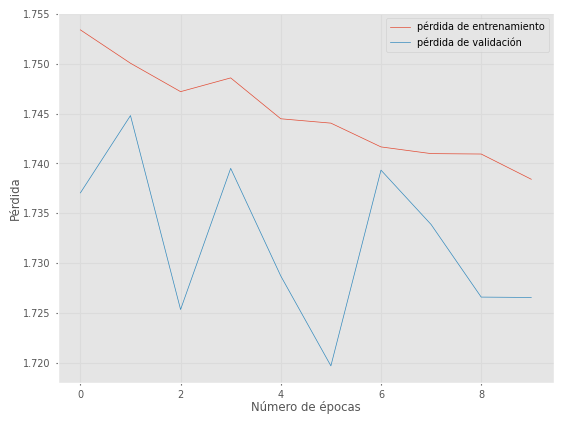

In [22]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='weightsT1.h5',
                                       monitor='val_loss', save_best_only=True)
# Entrena el modelo
history = model.fit(X_train, y_train,  epochs=10, batch_size=128, validation_split=0.2, callbacks=[checkpoint_callback])

plt.plot(history.history['loss'], label='pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='pérdida de validación')
plt.xlabel('Número de épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [12]:
# Evalúa el modelo en el conjunto de pruebas
model.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 1.7560 - mse: 1.7223 - accuracy: 0.7497


[1.7559930086135864, 1.7223377227783203, 0.7496500015258789]

In [13]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Roll,Pitch,Yaw,X,Y,Z
0,-1.2725,0.1765,-0.2675,1.2871,1.7241,1.7746,2.670896,1.240142,3.079316,0.16306,-0.29789,0.63213
1,2.1500,-0.3738,0.5203,-0.9932,-0.1559,0.3500,1.673083,-0.938626,-2.514319,-0.16200,0.23058,0.56218
2,2.4630,0.0588,0.1829,2.5025,0.8853,1.4526,0.929903,0.714333,-2.159952,-0.31731,0.21315,0.58774
3,-0.2220,-1.2199,0.8517,1.3264,-0.6319,4.3036,0.664402,-1.002397,1.485717,0.04312,-0.05204,0.58733
4,-2.8115,-0.5678,0.7310,0.8337,1.6392,5.3698,-2.387837,-0.468515,-2.128698,-0.12604,-0.09941,0.49080


In [14]:
# Hacer una predicción
example_input = [[2.670896,	1.240142,	3.079316,	0.16306,	-0.29789,	0.63213],[1.673083,	-0.938626,	-2.514319,	-0.16200,	0.23058,	0.56218]]
prediction = model.predict(example_input)

1/1 [==============================] - 0s 167ms/step


In [15]:
prediction[0]

array([ 0.18953474, -0.2284396 , -0.07235721,  0.04293622, -0.02075604,
        3.318845  ], dtype=float32)

In [18]:
print('Prueba')
robot.fkine(prediction[0])

Prueba


   0.2619   -0.2508    0.9319    0.27      
   0.2726    0.9455    0.1779    0.05172   
  -0.9258    0.2075    0.316     0.7321    
   0         0         0         1         


In [19]:
print('Real')
robot.fkine([-1.2725,	0.1765,	-0.2675,	1.2871,	1.7241,	1.7746])

Real


  -0.324    -0.3726    0.8696    0.1631    
   0.02021   0.9162    0.4002   -0.2979    
  -0.9458    0.1472   -0.2894    0.6321    
   0         0         0         1         


In [47]:
model.save('modelT2.h5')

In [152]:

model0 = tf.keras.models.load_model('modelT1.h5')

In [153]:
model0.evaluate(X_test, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 4.0171 - mse: 4.0087 - accuracy: 0.0994


[4.017067909240723, 4.008669376373291, 0.0994499996304512]

In [20]:
y_pred = model.predict(X_test)

625/625 [==============================] - 2s 3ms/step


In [156]:
example_input = [[0.16306,	-0.29789,	0.63213],[-0.16200,	0.23058,	0.56218]]
prediction = model0.predict(example_input)

1/1 [==============================] - 0s 180ms/step


In [157]:
print('Prueba')
robot.fkine(prediction[0])

Prueba


   0.5706    0.8094   -0.139     0.1731    
  -0.7851    0.5873    0.1968   -0.2304    
   0.241    -0.003197  0.9705    0.7086    
   0         0         0         1         


In [158]:
print('Real')
robot.fkine([-1.2725,	0.1765,	-0.2675,	1.2871	,1.7241	,1.7746])

Real


  -0.324    -0.3726    0.8696    0.1631    
   0.02021   0.9162    0.4002   -0.2979    
  -0.9458    0.1472   -0.2894    0.6321    
   0         0         0         1         


In [21]:
metrics.r2_score(y_test, y_pred)

0.23964545621500213